# 1. Setup

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns
import xgboost as xgb
from optuna.samplers import TPESampler
from pandas import DataFrame, Series, Timedelta
from sklearn.metrics import mean_absolute_error as MAE
from xgboost import DMatrix, XGBRegressor

In [ ]:
from utils.loading import load_all_raw_data
from utils.preprocessing import process_all_dfs
from utils.merging import merge_all_dfs
from utils.feature_engineering import *

In [ ]:
pd.set_option(
    "display.float_format",
    lambda x: f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}",
)
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 100)

In [ ]:
RAW_DATA_PATH = "../data/raw_data/"
ADDITIONAL_DATA_PATH = "../data/additional_data/"

SEGMENT_C = ["county", "product_type", "is_business"]
CATEGORICAL_C = ["county", "product_type", "is_business", "is_consumption"]
TARGET_C = [
    "county",
    "product_type",
    "is_business",
    "is_consumption",
    "datetime",
]
RAND = 10

In [ ]:
processed_dfs = process_all_dfs(
    load_all_raw_data(RAW_DATA_PATH, ADDITIONAL_DATA_PATH)
)

# processed_dfs.keys()
df = merge_all_dfs(processed_dfs, how="left")
df = add_dst_flag(df)
df = add_cyclic_datetime_features(df, drop_raw=True)

In [ ]:
for lag in [2, 3, 7]:
# for lag in range(2, 15):
    df = df.merge(
        get_lag(processed_dfs["train"][TARGET_C + ["target"]], lag=lag),
        how="left",
        on=TARGET_C,
    )

In [ ]:
for window in [24, 24 * 3, 24 * 7, 24 * 14]:
    # for window in [24 * i for i in range(1, 15)]:
    df = df.merge(
        get_moving_average(
            processed_dfs["train"]
            .set_index("datetime")
            .sort_index()
            .groupby(CATEGORICAL_C, observed=True, as_index=False),
            columns=["target"],
            window=window,
            # ).dropna(),
        ),
        how="left",
        on=TARGET_C,
    )

In [ ]:
df["t_over_cap"] = (df["2d_lag_target"] / df["installed_capacity"]).astype(
    "float32"
)
df["t_over_eic"] = (df["2d_lag_target"] / df["eic_count"]).astype("float32")
df["cap_per_eic"] = (df["installed_capacity"] / df["eic_count"]).astype(
    "float32"
)

In [ ]:
FEATURES_TO_DROP = ["datetime", "data_block_id", "date"]

# 2. Time Splits

In [ ]:
# VAL_SPLITS = 3
FH = 7 # weekly retraining

In [ ]:
# train - val - test
# .64 - .16 - .20

In [ ]:
train_dt_start = df["datetime"].min()
val_dt_start = (
    train_dt_start + (df["datetime"].max() - df["datetime"].min()) * 0.64
).normalize()
test_dt_start = (
    train_dt_start + (df["datetime"].max() - df["datetime"].min()) * 0.8
).normalize()

train_dt_end = val_dt_start - Timedelta(hours=1)
val_dt_end = test_dt_start - Timedelta(hours=1)
test_dt_end = df["datetime"].max()

train_range = (train_dt_end - train_dt_start).ceil('d')
val_range = (val_dt_end -  val_dt_start).ceil('d')
test_range = (test_dt_end - test_dt_start).ceil('d')

print(
    f"Train range starts: {train_dt_start}",
    f"Train range length: {train_range.days}",
    f"Train range ends: {train_dt_end}",
    
    f"Validation range starts: {val_dt_start}",
    f"Validation range length: {val_range.days}",
    f"Validation range ends: {val_dt_end}",
    
    f"Test range starts: {test_dt_start}",
    f"Test range length: {test_range.days}",
    f"Test range ends: {test_dt_end}",
    sep="\n",
)

Train range starts: 2021-09-01 00:00:00
Train range length: 408
Train range ends: 2022-10-13 23:00:00
Validation range starts: 2022-10-14 00:00:00
Validation range length: 102
Validation range ends: 2023-01-23 23:00:00
Test range starts: 2023-01-24 00:00:00
Test range length: 128
Test range ends: 2023-05-31 23:00:00


In [ ]:
splits = [
    {
        "train": (train_dt_start, train_dt_end),
        "val": (val_dt_start, val_dt_start + Timedelta(days=6, hours=23)),
    },
    {
        "train": (
            train_dt_start + val_range / 2 - Timedelta(days=3),
            train_dt_end + val_range / 2 - Timedelta(days=3),
        ),
        "val": (
            val_dt_start + val_range / 2 - Timedelta(days=3),
            val_dt_start
            + val_range / 2
            + Timedelta(days=6, hours=23)
            - Timedelta(days=3),
        ),
    },
    {
        "train": (
            train_dt_start + val_range - Timedelta(days=7),
            train_dt_end + val_range - Timedelta(days=7),
        ),
        "val": (
            val_dt_start + val_range - Timedelta(days=7),
            val_dt_start + val_range - Timedelta(hours=1),
        ),
    },
]

# for i, d in enumerate(splits):
#     print(i, "train", d["train"])
#     print(i, "valid", d["val"])
#     print(d["train"][1] - d["train"][0])
#     print(d["val"][1] - d["val"][0])

In [ ]:
# splits_fixed = split_by_equal_days(
#     dt=df.loc[df["datetime"] < test_dt_start, "datetime"],
#     train_days=train_days_range.days,
#     fh=FH, 
#     n_splits=VAL_SPLITS,
#     expanding=False,
# )

# new_splits = []

# for i, d in enumerate(splits_fixed):
#     count = len(
#         df.loc[
#             (df["datetime"] >= d["val"][0]) & (df["datetime"] <= d["val"][1])
#         ]
#     )
#     if count < 24:
#         print(f"Split {i} only has {count} rows, removed")
#     else:
#         new_splits.append(d)

# splits_fixed = new_splits
# for i, d in enumerate(splits_fixed):
#     print(i, "train", d["train"])
#     print(i, "valid", d["val"])

# 3. Baseline Model

In [ ]:
MODELS_DIR = Path("../models/xgb_baseline")
MODELS_DIR.mkdir( parents=True, exist_ok=True)

VERBOSE = 0
ESR = 50
baseline_params = {
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:absoluteerror",
    "eval_metric": "mae",
    "tree_method": "hist", # GPU
    "device": "cuda", # GPU
    "n_jobs": -1,
}

In [ ]:
baseline_predicts = np.empty(len(splits))

for idx, split in enumerate(splits):
    model_path = MODELS_DIR / f"baseline_split_{idx}.json"

    df_val = df[
        (df["datetime"] >= split["val"][0])
        & (df["datetime"] <= split["val"][1])
    ].drop(FEATURES_TO_DROP, axis=1)

    X_val, y_val = df_val.drop(["target"], axis=1), df_val["target"]
    del df_val

    dval = DMatrix(X_val, label=y_val, enable_categorical=True)
    del X_val

    if model_path.exists():
        booster = xgb.Booster()
        booster.load_model(str(model_path))
    else:
        df_train = df[
            (df["datetime"] >= split["train"][0])
            & (df["datetime"] <= split["train"][1])
        ].drop(FEATURES_TO_DROP, axis=1)

        X_train, y_train = (
            df_train.drop(["target"], axis=1),
            df_train["target"],
        )

        del df_train

        dtrain = DMatrix(X_train, label=y_train, enable_categorical=True)
        del X_train, y_train


        evals = [(dtrain, "train"), (dval, "val")]

        booster = xgb.train(
            params=baseline_params,
            dtrain=dtrain,
            num_boost_round=1000,
            evals=evals,
            early_stopping_rounds=ESR,
            verbose_eval=VERBOSE,
        )

        booster.save_model(str(model_path))
    
    preds = booster.predict(dval)
    baseline_predicts[idx] = MAE(y_val, preds)

print("Baseline MAE:", np.mean(baseline_predicts))

Baseline MAE: 32.601064682006836


# 4. Optuna Search

In [ ]:
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.03, 0.3),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "lambda": trial.suggest_float("lambda", 0.001, 100),
        "alpha": trial.suggest_float("alpha", 0.001, 100),
        "gamma": trial.suggest_float("gamma", 0, 10),
        "grow_policy": trial.suggest_categorical("grow_policy", ['depthwise', 'lossguide']),

        "random_state": RAND,
        "tree_method": "hist",
        "device": "cuda",
        "objective": "reg:absoluteerror",
        "eval_metric": "mae",
    }
    num_boost_round = trial.suggest_int("num_boost_round", 500, 2500, step=500)
    cv_predicts = np.empty(len(splits))

    for idx, split in enumerate(splits):
        df_train = df[
            (df["datetime"] >= split["train"][0])
            & (df["datetime"] <= split["train"][1])
        ].drop(FEATURES_TO_DROP, axis=1)
        df_val = df[
            (df["datetime"] >= split["val"][0])
            & (df["datetime"] <= split["val"][1])
        ].drop(FEATURES_TO_DROP, axis=1)

        X_train, y_train = (
            df_train.drop(["target"], axis=1),
            df_train["target"],
        )
        dtrain = DMatrix(X_train, label=y_train, enable_categorical=True)
        del X_train, y_train

        X_val, y_val = df_val.drop(["target"], axis=1), df_val["target"]
        dval = DMatrix(X_val, label=y_val, enable_categorical=True)
        del X_val

        evals = [(dtrain, "train"), (dval, "val")]

        booster = xgb.train(
            params=params,
            dtrain=dtrain,
            evals=evals,
            num_boost_round=num_boost_round,
            early_stopping_rounds=ESR,
            verbose_eval=VERBOSE,
        )

        preds = booster.predict(dval)
        cv_predicts[idx] = MAE(y_val, preds)

    return np.mean(cv_predicts)

In [ ]:
STORAGE = "sqlite:///../optuna_db/optuna_study_v3.db"
N_TRIALS = 120

In [ ]:
optuna.logging.set_verbosity(optuna.logging.INFO)

In [ ]:
study = optuna.create_study(
    storage=STORAGE,
    sampler=TPESampler(n_startup_trials=20, multivariate=True),
    pruner=optuna.pruners.SuccessiveHalvingPruner(),
    study_name="xgb_optuna",
    direction="minimize",
    load_if_exists=True,
)
existing_trials = len(study.trials)

if existing_trials >= N_TRIALS:
    print("Number of existing trials >= N_TRIALS. Skipping optimization.")
else:
    remaining = N_TRIALS - existing_trials
    print(f"Run {remaining} trials to reach {N_TRIALS}")
    study.optimize(
        objective,
        n_trials=remaining,
        show_progress_bar=True,
        n_jobs=1,
    )

/root/.cache/pypoetry/virtualenvs/jlpe-9TtSrW0h-py3.12/lib/python3.12/site-packages/optuna/_experimental.py:31: ExperimentalWarning: Argument ``multivariate`` is an experimental feature. The interface can change in the future.
  warnings.warn(
[I 2025-06-04 17:57:36,154] Using an existing study with name 'xgb_optuna' instead of creating a new one.


Number of existing trials >= N_TRIALS. Skipping optimization.


In [ ]:
# def objective(trial):
#     params = {
#         "n_estimators": trial.suggest_int("n_estimators", 500, 2000, step=500),
#         "learning_rate": trial.suggest_categorical("learning_rate", [0.05, 0.1, 0.2, 0.3]),
#         "max_depth": trial.suggest_int("max_depth", 3, 12),
#         "min_child_weight": trial.suggest_int("max_depth", 1, 20),
#         "subsample": trial.suggest_float("subsample", 0.5, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
#         "lambda": trial.suggest_float("colsample_bytree", 0.001, 100),
#         "alpha": trial.suggest_float("colsample_bytree", 0.001, 100)

#         "early_stopping_rounds": OPTUNA_ESR,
#         "random_state": RAND,

#         "objective": "reg:absoluteerror",
#         "eval_metric": "mae",
#         "enable_categorical": True,
#         "n_jobs": -1,
#     }
#     model = XGBRegressor(**params)

#     splits_fixed = split_by_equal_days(
#         dt=df.loc[df["datetime"] < test_dt_start, "datetime"],
#         train_days=train_days_range,
#         fh=7, # weekly retraining
#         n_splits=VAL_SPLITS,
#         expanding=False,
#     )
#     cv_predicts = np.empty(VAL_SPLITS)

#     for idx, split in enumerate(splits_fixed):
#         df_train = df[
#             (df["datetime"] >= split["train"][0])
#             & (df["datetime"] <= split["train"][1])
#         ].drop(FEATURES_TO_DROP, axis=1)
#         df_val = df[
#             (df["datetime"] >= split["val"][0])
#             & (df["datetime"] <= split["val"][1])
#         ].drop(FEATURES_TO_DROP, axis=1)
    
#         X_train, y_train = (
#             df_train.drop(["target"], axis=1),
#             df_train["target"],
#         )
#         X_val, y_val = df_val.drop(["target"], axis=1), df_val["target"]
#         # X_test, y_test = df_test.drop(["target"], axis=1), df_test["target"]
#         eval_set = [
#             (X_train, y_train),
#             (X_val, y_val),
#             # (X_test, y_test)
#         ]

#         model.fit(
#             X_train,
#             y_train,
#             eval_set=eval_set,
#             verbose=VERBOSE,
#         )

#         preds = model.predict(X_val)
#         cv_predicts[idx] = MAE(y_val, preds)

#     return np.mean(cv_predicts)

In [ ]:
# study = optuna.create_study(
#     direction="minimize",
#     pruner=optuna.pruners.SuccessiveHalvingPruner(),
#     study_name="xgb_optuna",
# )

# study.optimize(objective, n_trials=15, show_progress_bar=True, n_jobs=1)
# # >1h 10 n_jobs=-1

In [ ]:
study.best_params
# {'n_estimators': 1000, 'learning_rate': 0.05, 'max_depth': 12}
# 30.988663991292317

# {'learning_rate': 0.1,
# 'max_depth': 10,
# 'min_child_weight': 18,
# 'subsample': 0.8594561164418333,
# 'colsample_bytree': 0.9549790028777667,
# 'lambda': 80.67437718316565,
# 'alpha': 8.579982090257277,
# 'num_boost_round': 1500}
# 30.306320826212566


# {'learning_rate': 0.10842258169357744,
#  'max_depth': 10,
#  'min_child_weight': 9,
#  'subsample': 0.968120281133485,
#  'colsample_bytree': 0.9514698765601128,
#  'lambda': 56.77594835612019,
#  'alpha': 36.40618084787037,
#  'num_boost_round': 1000}
# 30.03012466430664

{'learning_rate': 0.030955675074240654,
 'max_depth': 10,
 'min_child_weight': 17,
 'subsample': 0.71406166804621,
 'colsample_bytree': 0.9624060929298566,
 'lambda': 9.471729484332482,
 'alpha': 7.15583334402845,
 'gamma': 1.9220011950179496,
 'grow_policy': 'depthwise',
 'num_boost_round': 2000}

In [ ]:
study.best_value

29.195664087931316

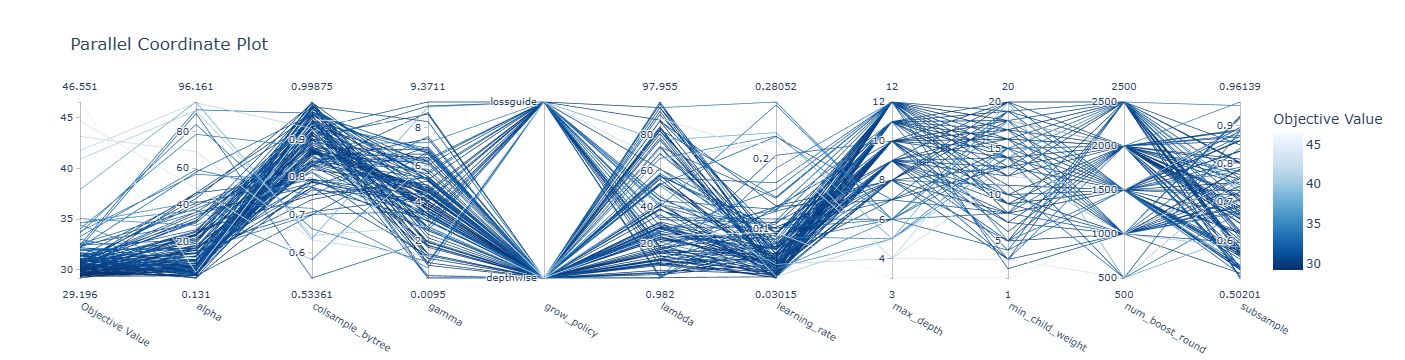

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

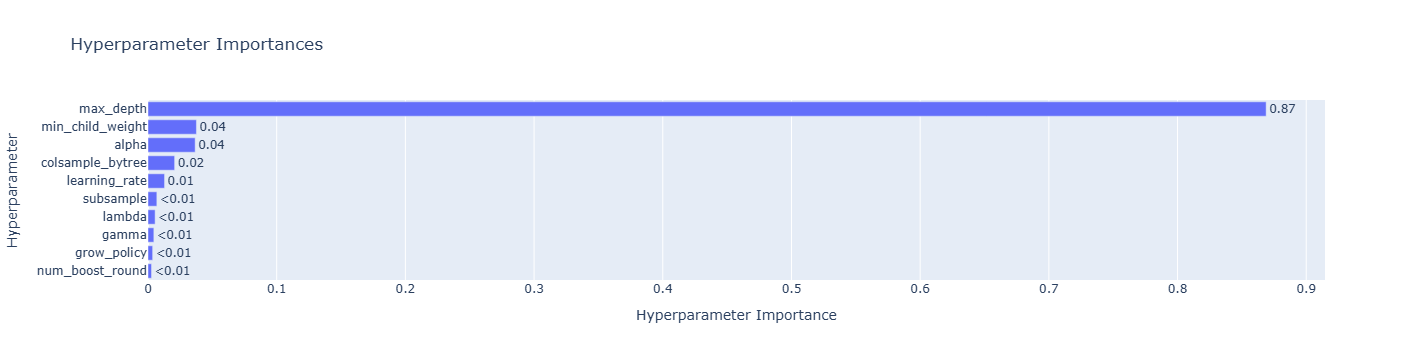

In [ ]:
optuna.visualization.plot_param_importances(study)

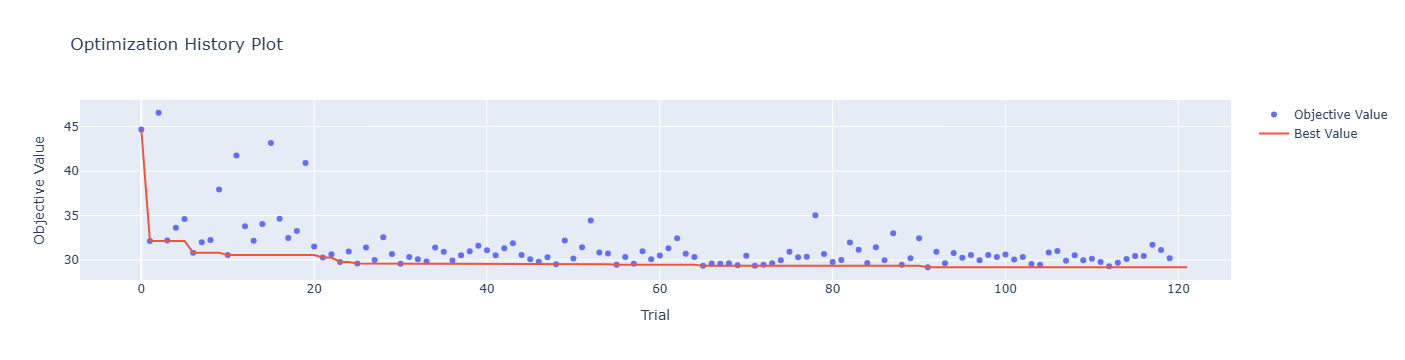

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
# optuna.visualization.plot_contour(study)

In [ ]:
# for split in [[xgb_mae_history[i]["validation_1"]["mae"][-1] for i in range(split * 5, split * 5 + 5)] for split in range(4)]:
#     print(np.round(np.mean(split), 3))

# for split in [[lgbm_mae_history[i]["valid_1"]["l1"][-1] for i in range(split * 5, split * 5 + 5)] for split in range(4)]:
#     print(np.round(np.mean(split), 3))

# for split in [[cb_mae_history[i]["validation_1"]["MAE"][-1] for i in range(split * 5, split * 5 + 5)] for split in range(4)]:
#     print(np.round(np.mean(split), 3))

# [[i for i in range(split * 5, split * 5 + 5)] for split in range(4)]

# residuals = y_test - y_pred

# plt.scatter(y_pred, residuals, alpha=0.5)
# plt.axhline(0, color="red", linestyle="--")
# plt.xlabel("Predicted")
# plt.ylabel("Residuals")
# plt.title("Residuals vs Predicted")
# plt.show()

# fi = pd.Series(xgbr.feature_importances_, index=X_train.columns)
# fi = fi.sort_values(ascending=False).head(20)

# fi.plot.barh(figsize=(8,6))
# plt.xlabel("Feature Importance")
# plt.gca().invert_yaxis()
# plt.title("Top 20 Important Features")
# plt.show()